by Luis Vazquez

# Contextualization
SIB(Small Industries Bank) loans money to companies in exchange for the promise of repayment. Given a number of metrics, we are to find whether a client for the bank will be defaulting on their loan or not.

# Loading imports and data:

In [1]:
#Basic data processing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn.metrics as met
from sklearn.model_selection import train_test_split, RandomizedSearchCV
#Trying different models for classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from matplotlib.colors import ListedColormap

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Understanding the data

In [3]:
train.head()

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
0,4050975007,Others,VA,27-Apr-10,34,4,New,0,Rural,N,"$35,000.00","$35,000.00",1
1,3735095001,Manufacturing,CA,05-Nov-09,107,1,New,0,Rural,N,"$15,000.00","$13,500.00",1
2,3936555004,Trading,CA,26-Feb-10,84,1,New,0,Rural,Y,"$265,000.00","$100,000.00",0
3,4130405000,Engineering,MI,10-Jun-10,240,21,New,0,Rural,N,"$255,000.00","$255,000.00",0
4,4263615008,Education,NH,23-Sep-10,36,1,Existing,0,Rural,N,"$13,300.00","$6,650.00",0


We have 12 different columns, after discounting the default status, with only 6 of them being purely numerical and one of them being the index which will not be used. We will require to categorize some of the features as well as create a few new ones

In [4]:
train.isnull().sum()

id                0
industry          1
state             0
request_date      0
term              0
employee_count    0
business_new      0
business_type     0
location          0
other_loans       0
loan_amount       0
insured_amount    0
default_status    0
dtype: int64

In [5]:
test.isnull().sum()

id                0
industry          0
state             0
request_date      0
term              0
employee_count    0
business_new      0
business_type     0
location          0
other_loans       0
loan_amount       0
insured_amount    0
dtype: int64

Only one record in the train set is empty or null, we will remove it from the data set altogether as it is not a significant portion of the records.

In [6]:
train = train.dropna()

In [7]:
train.isnull().sum()

id                0
industry          0
state             0
request_date      0
term              0
employee_count    0
business_new      0
business_type     0
location          0
other_loans       0
loan_amount       0
insured_amount    0
default_status    0
dtype: int64

In [8]:
train.default_status.value_counts()

0    1628
1     773
Name: default_status, dtype: int64

**id**: Is a non relevant factor and will be dropped later

**Industry**: We will start by analyzing if type of industry has any influence on probability of defaulting loan

,default_status
industry,
Trading,508
Construction,275
Consulting,267
Hotel,245
Manufacturing,245
Healthcare,219
Others,168
Administration,125
Transportation,106


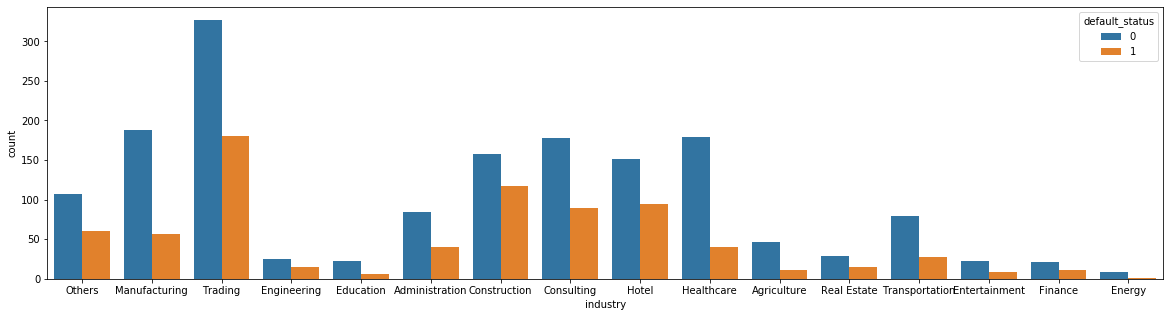

In [9]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="industry", hue="default_status", data=train)
train[['industry', 'default_status']].groupby(['industry']).count().sort_values(by='default_status', ascending=False)

,default_status
industry,
Construction,0.425455
Hotel,0.383673
Engineering,0.375000
Others,0.363095
Trading,0.356299
Finance,0.343750
Real Estate,0.340909
Consulting,0.333333
Administration,0.320000


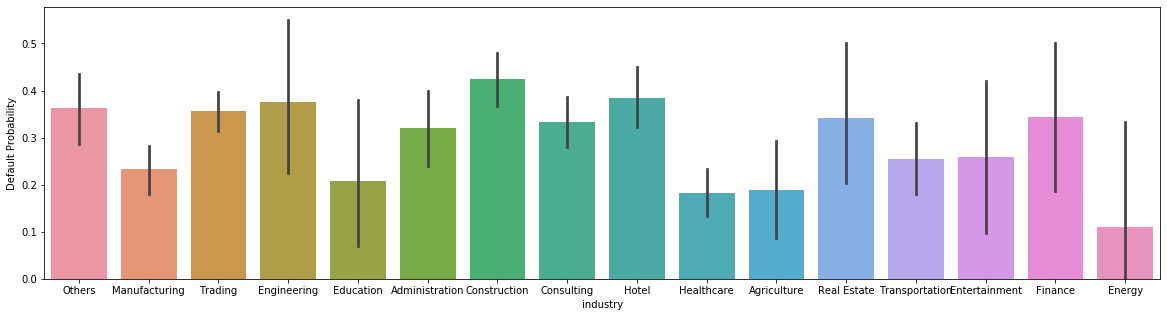

In [10]:
plt.figure(figsize=(20,5))
g = sns.barplot(x="industry",y="default_status",data=train)
g = g.set_ylabel("Default Probability")
train[['industry', 'default_status']].groupby(['industry']).mean().sort_values(by='default_status', ascending=False)

None of the Industries show a particularly high rate of defaulting, however due to the low amount of data in some of them, their variance seems to be less stable, such as with Energy Industry. Values will be converted into numerical categories by getting their dummy values in new columns.

**State** More data that is not numerically categorized. If no pattern is identified from the different data, this feature will be considered for removal.

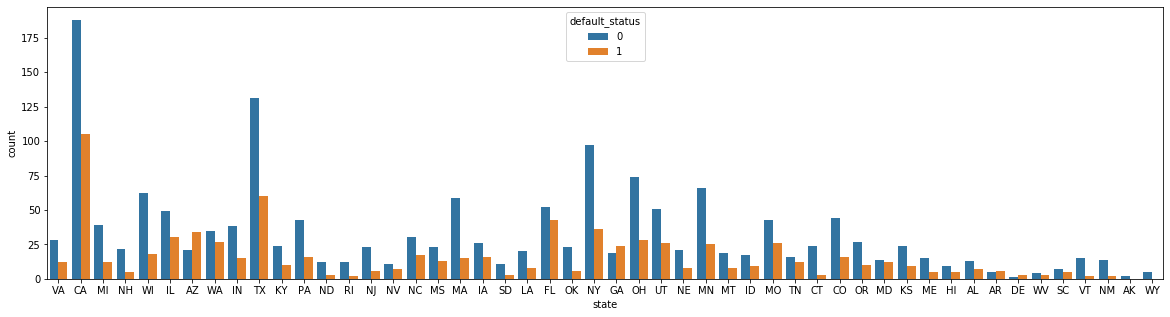

In [11]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="state", hue="default_status", data=train)


,default_status
state,
DE,0.750000
AZ,0.618182
GA,0.558140
AR,0.545455
MD,0.461538
FL,0.452632
WA,0.435484
WV,0.428571
TN,0.428571


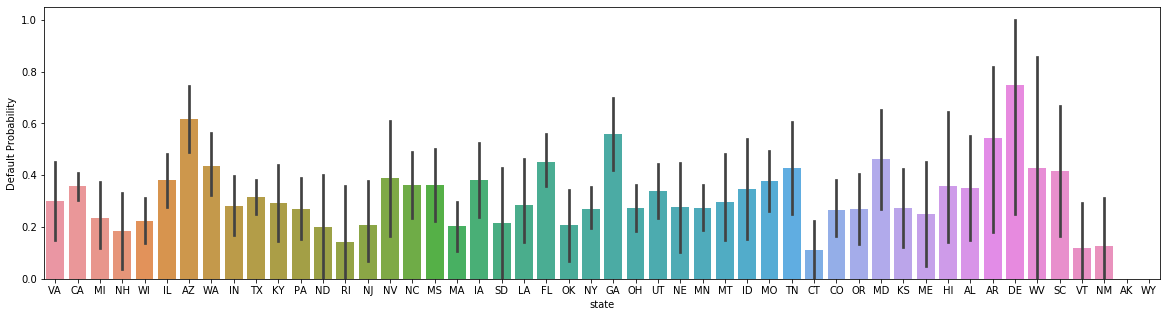

In [12]:
plt.figure(figsize=(20,5))
g = sns.barplot(x="state",y="default_status",data=train)
g = g.set_ylabel("Default Probability")
train[['state', 'default_status']].groupby(['state']).mean().sort_values(by='default_status', ascending=False)

From the observed above, a higher chance to incur in a default is observed from states where the economy for small businesses are not as highly thriving as the more densely populated states. Such is the example of Denver, Arizona, Georgia and Arkansas. However in contrast to this, some of the states that have much more active economies for Small businesses such as California and Washington are close to split evenly in their chances of defaulting. As such this feature will be removed as it does not provide enough variance.

**request date**: As a non discrete value, it needs to be discretized in a way that allows us to get insights into the data

In [13]:
train['request_date'] = pd.to_datetime(train['request_date'])

In [14]:
print(train.request_date.max())
print(train.request_date.min())

2010-09-30 00:00:00
2009-10-01 00:00:00


In [15]:
dates_train = train[['request_date', 'default_status']]
dates_train['month_year'] = pd.to_datetime(dates_train.request_date).dt.to_period('M')
dates_train = dates_train.sort_values(by=['month_year'])
dates_train.head()

D:\Miniconda3\envs\playground\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,request_date,default_status,month_year
946,2009-10-09,1,2009-10
1743,2009-10-29,0,2009-10
2022,2009-10-16,0,2009-10
2021,2009-10-14,0,2009-10
2013,2009-10-07,0,2009-10


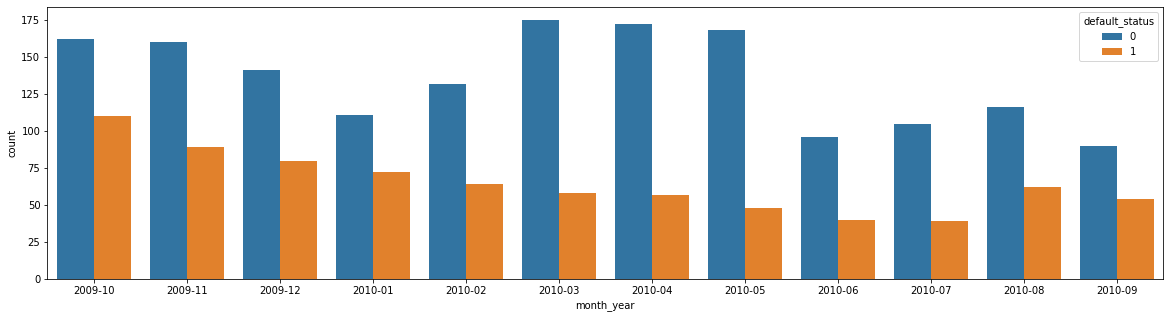

In [16]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="month_year", hue="default_status", data=dates_train)

With only 1 year of data and no previous historical records, it is not a significant factor in the analysis. This feature will be later dropped

**term**: We will observe the distribution of terms.

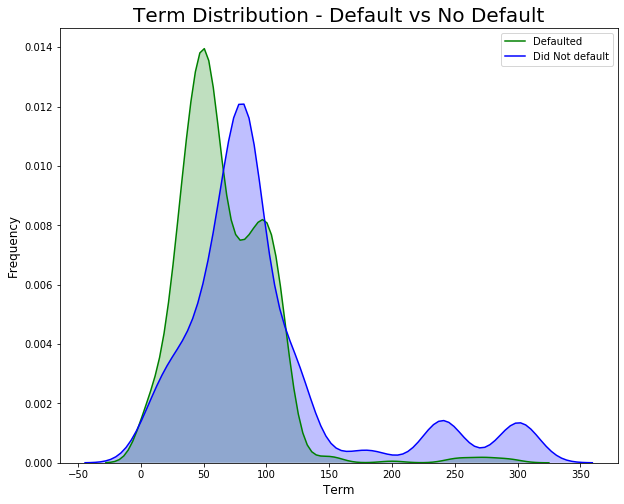

In [17]:
fig = plt.figure(figsize=(10,8),)
axis = sns.kdeplot(train.loc[(train['default_status'] == 1),'term'] , color='g',shade=True, label='Defaulted')
axis = sns.kdeplot(train.loc[(train['default_status'] == 0),'term'] , color='b',shade=True,label='Did Not default')
plt.title('Term Distribution - Default vs No Default', fontsize = 20)
plt.xlabel("Term", fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);

Short term loans appear to be more likely to default. As this feature is already numerical, it will be left as is.

**employee count**: We will also analyse its distribution:

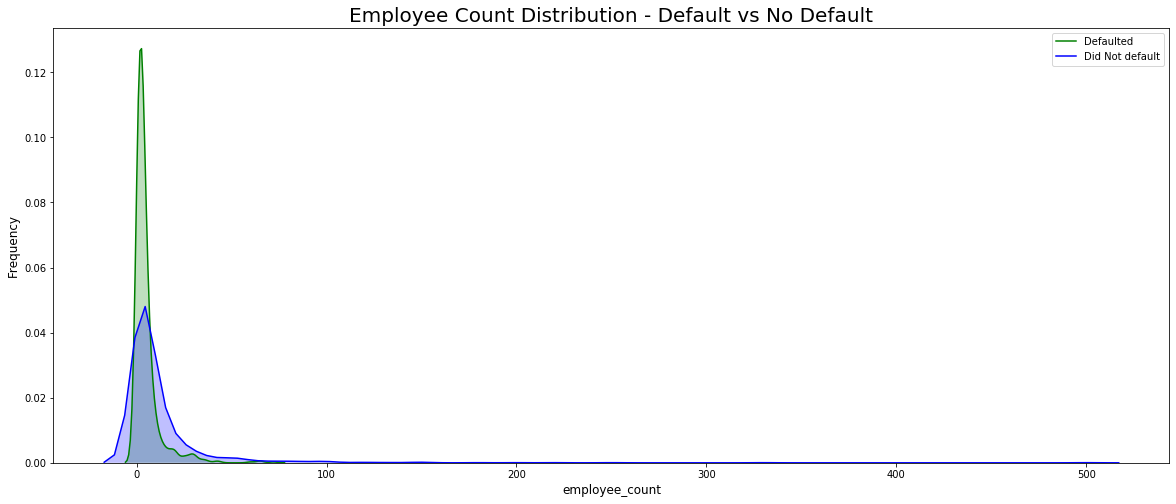

In [18]:
fig = plt.figure(figsize=(20,8),)
axis = sns.kdeplot(train.loc[(train['default_status'] == 1),'employee_count'] , color='g',shade=True, label='Defaulted')
axis = sns.kdeplot(train.loc[(train['default_status'] == 0),'employee_count'] , color='b',shade=True,label='Did Not default')
plt.title('Employee Count Distribution - Default vs No Default', fontsize = 20)
plt.xlabel("employee_count", fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);

Companies with very few employees do appear to have more chance of defaulting, As it is numerical, it will be left as is but normalized during feature engineering

**business new**: Text type data, will be converted to numerical and analyse its correlation during feature engineering

**business_type**: Only 2 different types of data, will leave as is

,default_status
business_type,
0,0.325253
1,0.265152


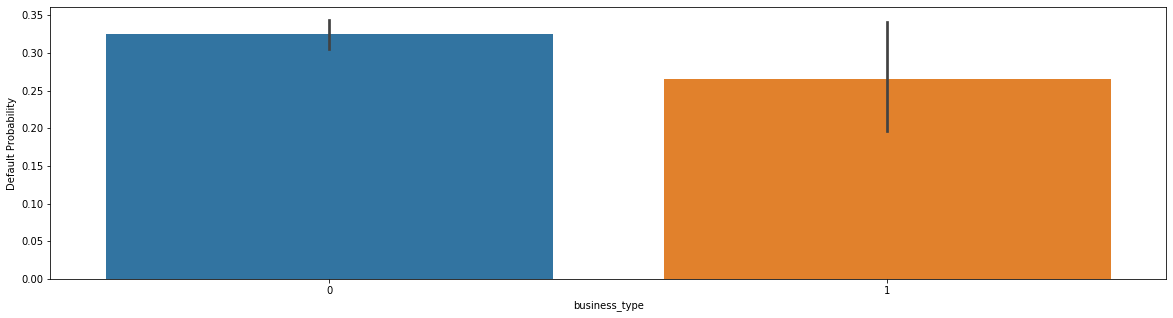

In [19]:
plt.figure(figsize=(20,5))
g = sns.barplot(x="business_type",y="default_status",data=train)
g = g.set_ylabel("Default Probability")
train[['business_type', 'default_status']].groupby(['business_type']).mean().sort_values(by='default_status', ascending=False)

**Location**: All locations are rural, this feature will be deleted as it does not bring any usable insights

In [20]:
train.location.unique()

array(['Rural'], dtype=object)

**other loans, loan amount** and **insured amount** require processing before analysis of feature, to be done during feature engineering and potentially removing some of the features, a new feature **uninsured amount** can be obtained from subtracting the insured amount from the loan amount:

In [21]:
train.head()

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
0,4050975007,Others,VA,2010-04-27,34,4,New,0,Rural,N,"$35,000.00","$35,000.00",1
1,3735095001,Manufacturing,CA,2009-11-05,107,1,New,0,Rural,N,"$15,000.00","$13,500.00",1
2,3936555004,Trading,CA,2010-02-26,84,1,New,0,Rural,Y,"$265,000.00","$100,000.00",0
3,4130405000,Engineering,MI,2010-06-10,240,21,New,0,Rural,N,"$255,000.00","$255,000.00",0
4,4263615008,Education,NH,2010-09-23,36,1,Existing,0,Rural,N,"$13,300.00","$6,650.00",0


# Feature Engineering:

This is what will be done with the  respective features:

**id**: To be left as is

**Industry**: Get dummy values, eliminate columns with low variance

**state**: To be removed

**request_date**: To be removed

**Term**: Numerical, leave as is, normalize later

**employee count**: Leave as is, normalize later

**business new**: Transform to numerical

**business type**: Leave as is

**location**: Drop feature

**other loans**: Convert to numerical

**loan amount**: Convert to numerical

**insured amount**: Conver to numerical, get uninsured amount from this and delete original feature


In [22]:
def common_cleanup(data):
    data['business_new'] = data['business_new'].replace('New', 1)
    data['business_new'] = data['business_new'].replace('Existing', 0)
    data['other_loans'] = data['other_loans'].replace('Y', 1)
    data['other_loans'] = data['other_loans'].replace('N', 0)
    data['loan_amount'] = data['loan_amount'].replace('[\$,]', '', regex=True).astype(float)
    data['insured_amount'] = data['insured_amount'].replace('[\$,]', '', regex=True).astype(float)
    data['uninsured_amount'] = data['loan_amount'] - data['insured_amount']
    data.drop(columns=['state','request_date','location'], inplace=True)

In [23]:
common_cleanup(train)
common_cleanup(test)

Obtaining the dummies for all industry values

In [24]:
train = pd.get_dummies(train, columns = ["industry"])
test = pd.get_dummies(test, columns = ["industry"])

In [25]:
train.head()

,id,term,employee_count,business_new,business_type,other_loans,loan_amount,insured_amount,default_status,uninsured_amount,...,industry_Engineering,industry_Entertainment,industry_Finance,industry_Healthcare,industry_Hotel,industry_Manufacturing,industry_Others,industry_Real Estate,industry_Trading,industry_Transportation
0,4050975007,34,4,1,0,0,35000.0,35000.0,1,0.0,...,0,0,0,0,0,0,1,0,0,0
1,3735095001,107,1,1,0,0,15000.0,13500.0,1,1500.0,...,0,0,0,0,0,1,0,0,0,0
2,3936555004,84,1,1,0,1,265000.0,100000.0,0,165000.0,...,0,0,0,0,0,0,0,0,1,0
3,4130405000,240,21,1,0,0,255000.0,255000.0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,4263615008,36,1,0,0,0,13300.0,6650.0,0,6650.0,...,0,0,0,0,0,0,0,0,0,0


# Creating a Model:
First we will separate the target data from the training set and removing the id altogether. We will keep the ID for the test set as it will be used for the final results.

In [26]:
test_ids = test.id
test_data = test.drop(columns=['id'])
train_targets = train.default_status
train_data = train.drop(columns=['id', 'default_status'])
test_data = test.drop(columns=['id'])

We will normalize all data features:

In [57]:
scaler = StandardScaler()
train_data_norm = scaler.fit_transform(train_data)
test_data_norm = scaler.transform(test_data)

For our training data, we divide in internal train and test in order to verify our performance

In [29]:
x_train, x_test, y_train, y_test = train_test_split(train_data_norm, train_targets, test_size=.2, random_state=4)

# Deciding on a model:
As we face on a classifier and the dataset is not big, we can test a few of them and compare their performance before tuning a specific algorithm.

In [30]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(n_estimators=100, max_depth=7, max_features=12),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(penalty='l2', C=10, max_iter=100)]

In [31]:
for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    print("The score for "+name+" is")
    print("Training: {:6.2f}%".format(100*clf.score(x_train, y_train)))
    print("Test: {:6.2f}%".format(100*clf.score(x_test, y_test)))
    print(" ")

The score for Nearest Neighbors is
Training:  86.88%
Test:  75.26%
 
The score for Linear SVM is
Training:  72.92%
Test:  71.93%
 
The score for RBF SVM is
Training:  83.70%
Test:  77.13%
 
The score for Gaussian Process is
Training:  74.53%
Test:  73.18%
 
The score for Decision Tree is
Training:  87.50%
Test:  83.16%
 
The score for Random Forest is
Training:  93.65%
Test:  85.86%
 
The score for Neural Net is
Training:  76.46%
Test:  72.35%
 
The score for AdaBoost is
Training:  88.39%
Test:  85.45%
 
The score for Naive Bayes is
Training:  46.82%
Test:  47.40%
 
The score for QDA is
Training:  56.82%
Test:  60.08%
 
The score for Logistic Regression is
Training:  72.76%
Test:  71.52%
 


D:\Miniconda3\envs\playground\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


From the tested algorithms, the best performing was Random Forest, therefore we will seek to further increase its performance through parameter tuning

# Optimizing the parameters of the best performing algorithm:

In [32]:
def rscv_tuning(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                                  n_jobs=-1, n_iter=nbr_iter, cv=5)
    
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [33]:
est = RandomForestClassifier()
params = {
        "n_estimators" : [20,50,100,150,200] ,
        "max_depth" : [3,7,15,21],
        "max_features" : (3,6,9,12,15),
        "min_samples_split" : (2,4,8),
        "criterion": ['gini', 'entropy'],
        "min_samples_leaf": [1,3,5,7]
        }

In [45]:
rscv_tuning(est, params, 5, train_data_norm, train_targets)

({'n_estimators': 50,
  'min_samples_split': 4,
  'min_samples_leaf': 1,
  'max_features': 15,
  'max_depth': 15,
  'criterion': 'entropy'},
 0.8892143104643104)

Results vary from different test runs, so far the best estimation are with the found parameters:

{'n_estimators': 50,

  'min_samples_split': 4,
  
  'min_samples_leaf': 1,
  
  'max_features': 15,
  
  'max_depth': 15,
  
  'criterion': 'entropy'}

In [54]:
forest = RandomForestClassifier(n_estimators=50, min_samples_split= 4, min_samples_leaf= 1, max_features = 15, max_depth= 15, criterion='entropy')
forest.fit(x_train, y_train)
print("The score for Random Forest is")
print("Training: {:6.2f}%".format(100*forest.score(x_train, y_train)))
print("Validate: {:6.2f}%".format(100*forest.score(x_test, y_test)))
print("Log-loss: {:6.4f}".format(met.log_loss(y_test, forest.predict_proba(x_test))))

The score for Random Forest is
Training:  99.27%
Validate:  87.53%
Log-loss: 0.3408


We will feed all the train data for model fitting before obtaining the final predictions of our test data.

In [91]:
forest.fit(train_data_norm, train_targets)
predictions = forest.predict(test_data_norm)
test['default_status'] = predictions

In [94]:
print(test.default_status.value_counts())
print(train.default_status.value_counts())
#Ratio of defaults to non defaults appears to be similar to the expected results based on the training data.

0    406
1    195
Name: default_status, dtype: int64
0    1628
1     773
Name: default_status, dtype: int64


In [93]:
submissions = test[['id','default_status']] 
submissions.to_csv('results_luisvazquez.csv', index=False)

As final insights, number of terms, employee counts and whether the company in question had other loans turned out to be significant factors for recognizing whether a company would end up defaulting on a loan or not.
Having a bigger dataset with insights on previous years would likely help the model identify with a higher confidence which companies are likely to default.


However as we are using RandomForest, escalability might not be as straightforward as the complexity of the model will increase the need in resource and time to calculate predictions, a bigger dataset would require analysing the use of more efficient models.